# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import warnings
# warnings.filterwarnings('ignore')

In [6]:
from sklearn.decomposition import PCA

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/scmemo')
import estimator, simulate, scmemo, bootstrap, util, hypothesis_test

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [397]:
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig5/'
data_path = '/data/parameter_estimation/'

### Load the data

In [10]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']
label_converter = dict(zip(cts, ['Th', 'cM', 'ncM', 'NK', 'Tc', 'B']))

In [11]:
def simplify_name(name):
    return name.split('.')[0]

In [12]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')


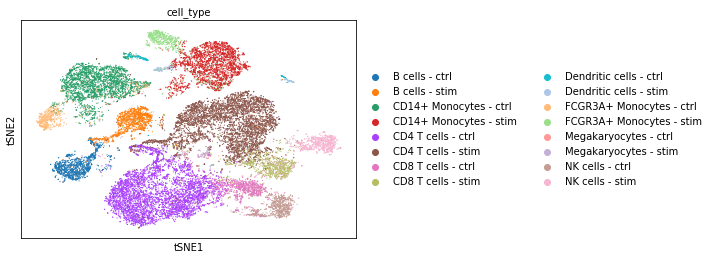

In [13]:
sc.pl.tsne(adata, color='cell_type')

In [14]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [15]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 35635


In [16]:
with open(data_path + 'all_highcount_tfs.pkl', 'rb') as f:
	tfs = pkl.load(f)

### Plotting functions

In [298]:
cts

['CD4 T cells',
 'CD14+ Monocytes',
 'FCGR3A+ Monocytes',
 'NK cells',
 'CD8 T cells',
 'B cells']

In [319]:
def get_ct_ind_corr(adata, gene_1, gene_2):
    
    adata_temp = adata.copy()
    scmemo.create_groups(adata_temp, label_columns=['stim','ind'], inplace=True)
    scmemo.compute_1d_moments(
        adata_temp, inplace=True, filter_genes=False, 
        residual_var=True, use_n_umi=False, filter_mean_thresh=0.0, 
        min_perc_group=0.0)
    scmemo.compute_2d_moments(adata_temp, [gene_1], [gene_2])
    df_list = []
    for group in adata_temp.uns['scmemo']['groups']:
        _, stim, ind = group.split('^')
        df_list.append((stim,ind,adata_temp.uns['scmemo']['2d_moments'][group]['corr'][0][0]))
    return pd.DataFrame(df_list, columns=[ 'stim','ind', 'corr'])

### Change in correlation in response to IFN-B in all PBMCs

In [128]:
imp.reload(estimator)
imp.reload(hypothesis_test)
imp.reload(bootstrap)
imp.reload(scmemo)

adata_ct =  adata.copy()#adata[adata.obs.cell == 'B cells'].copy()
# adata_ct.obs['stim'] = np.random.choice(adata_ct.obs['stim'], adata_ct.shape[0])
scmemo.create_groups(adata_ct, label_columns=['stim', 'ind'], inplace=True)

scmemo.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True, use_n_umi=False, filter_mean_thresh=0.07, 
    min_perc_group=0.7)
print('Size of data', adata_ct.shape)

available_tfs = list(set(tfs) & set(adata_ct.var.index.tolist()))
target_genes = adata_ct.var.index.tolist()
print('TF list length', len(available_tfs))
scmemo.compute_2d_moments(adata_ct, available_tfs, target_genes)

Size of data (24495, 1861)
TF list length 29


In [129]:
%%time
# scmemo.ht_2d_moments(
#     adata_ct, 
#     formula_like='1 + stim', 
#     cov_column='stim', 
#     num_cpus=6, 
#     num_boot=10000)

# adata_ct.write(data_path + 'result_2d/stim_all_pbmc.h5ad')

adata_ct = sc.read(data_path + 'result_2d/stim_all_pbmc.h5ad')

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   12.7s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:   56.9s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  6.0min
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed: 12.3min
[Parallel(n_jobs=6)]: Done 2036 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 2580 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 3860 tasks      | elapsed: 30.3min
[Parallel(n_jobs=6)]: Done 4596 tasks      | elapsed: 34.8min
[Parallel(n_jobs=6)]: Done 5396 tasks      | elapsed: 40.0min
[Parallel(n_jobs=6)]: Done 6260 tasks      | elapsed: 48.8min
[Parallel(n_jobs=6)]: Done 7188 tasks      | elapsed: 59.4min


CPU times: user 6min 32s, sys: 15 s, total: 6min 47s
Wall time: 7h 30min 16s


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


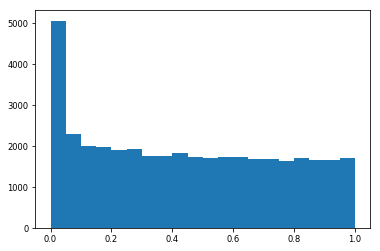

In [352]:
plt.hist(adata_ct.uns['scmemo']['2d_ht']['corr_asl'].ravel(), bins=20);

In [294]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

result_df = scmemo.get_2d_ht_result(adata_ct).dropna()

valid_counts = result_df.groupby('gene_1').size()
valid_tfs = valid_counts[valid_counts > 1300].index.tolist()

result_df = result_df.query('gene_1 in @valid_tfs')

mat = adata_ct.uns['scmemo']['2d_ht']['corr_coef'].T
mat = np.clip(mat, a_min=-0.6, a_max=.6)

heatmap_df = pd.DataFrame(mat, index=target_genes, columns=available_tfs)[valid_tfs].fillna(0.0)

1240


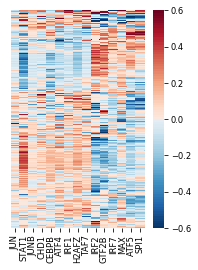

In [398]:
# Draw the heatmap
cg = sns.clustermap(
    heatmap_df[['JUN', 'STAT1','JUNB', 'CHD1','CEBPB', 'ATF4', 'IRF1', 'H2AFZ', 'TAF7', 'IRF2', 'GTF2B', 'IRF7', 'MAX','ATF5', 'SPI1']], 
    col_cluster=False
    );
cg.ax_row_dendrogram.set_visible(False)
col_order = ['JUN', 'STAT1','JUNB', 'CHD1','CEBPB', 'ATF4', 'IRF1', 'H2AFZ', 'TAF7', 'IRF2', 'GTF2B', 'IRF7', 'MAX','ATF5', 'SPI1']
row_order = cg.dendrogram_row.reordered_ind
plt.close()

select_rows = row_order[:int(len(row_order)/1.5)]
print(len(select_rows))
plt.figure(figsize=(3, 4))
sns.heatmap(heatmap_df[col_order].iloc[select_rows, :], cmap=sns.color_palette("RdBu_r", 100)[:45] + sns.color_palette("RdBu_r", 100)[55:],yticklabels=[])
plt.savefig(fig_path + 'tf_heatmap.pdf', bbox_inches='tight')

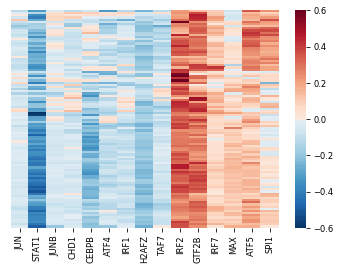

In [364]:
new_heatmap_df = heatmap_df[col_order].iloc[select_rows, :]
sns.heatmap(new_heatmap_df.iloc[200:300], cmap=sns.color_palette("RdBu_r", 100)[:45] + sns.color_palette("RdBu_r", 100)[55:],yticklabels=[])
genes_1 = new_heatmap_df.iloc[200:300].index.tolist()

In [365]:
print(genes_1)

['DYNLT1', 'GBP5', 'GBP1', 'LAP3', 'MYO1G', 'MBOAT7', 'DDAH2', 'DNAJA1', 'IFI35', 'NAGK', 'WARS', 'SCARB2', 'SNX10', 'OAS1', 'MS4A6A', 'SLC31A2', 'IL4I1', 'PLEK', 'CCRL2', 'C3AR1', 'BST2', 'MGAT1', 'CREG1', 'HPSE', 'CCL2', 'CDKN1A', 'SFT2D1', 'LYN', 'RIT1', 'SHKBP1', 'TNFRSF1A', 'GCLM', 'IRF7', 'TCIRG1', 'ATP6V0D1', 'RNF130', 'AGTRAP', 'GPSM3', 'CYB5R4', 'ATP6V1C1', 'ENY2', 'LACTB', 'GRINA', 'CD48', 'PPP1R15A', 'PLSCR1', 'NAMPT', 'HSBP1', 'GRB2', 'VRK2', 'RAB10', 'PTPRE', 'CCR1', 'NINJ1', 'FNDC3B', 'ATP6V0B', 'CTSZ', 'FTH1', 'PLA2G7', 'CLEC4E', 'S100A10', 'LGALS1', 'FTL', 'ATP6V1F', 'CTSB', 'CFP', 'S100A6', 'GSTO1', 'S100A4', 'C15orf48', 'GRN', 'S100A11', 'LILRB4', 'ANXA2', 'ANXA5', 'CD63', 'KYNU', 'PSAP', 'SOD2', 'SPI1', 'TYROBP', 'CD68', 'FCER1G', 'TYMP', 'BRI3', 'CTSL', 'CSTB', 'LYZ', 'FCGRT', 'SDCBP', 'CTSS', 'CLIC1', 'CFD', 'EMP3', 'DUSP6', 'IGSF6', 'CST3', 'FCN1', 'NPC2', 'GABARAP']


In [ ]:
for gene in genes_1:
    print('---')
    print(df.query('gene_2 == "{}" & gene_1 in @col_order & corr_fdr < 0.1'.format(gene)).sort_values('corr_coef'))

In [369]:
print(df.query('gene_2 == "{}" & gene_1 in @col_order & corr_fdr < 0.1'.format('IL4I1')).sort_values('corr_coef'))

      gene_1 gene_2  corr_coef     corr_pval  corr_fdr
40864  H2AFZ  IL4I1 -0.239784   2.750818e-07  0.000070
20393  STAT1  IL4I1 -0.210088   2.058936e-05  0.001351
18532  IRF1   IL4I1 -0.101022   1.825373e-03  0.056469
25976  JUN    IL4I1 -0.073578   1.556673e-05  0.001055
11088  IRF7   IL4I1  0.168624   3.426383e-03  0.085032
29698  SPI1   IL4I1  0.243244   2.258179e-07  0.000067
22254  GTF2B  IL4I1  0.300408   4.152454e-03  0.096417
35281  ATF5   IL4I1  0.368023   3.340699e-04  0.014433
37142  IRF2   IL4I1  0.445158   4.343105e-03  0.098846


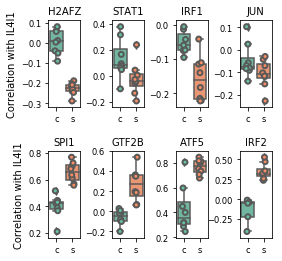

In [399]:
tf_list = df.query('gene_2 == "{}" & gene_1 in @col_order & corr_fdr < 0.1'.format('IL4I1')).sort_values('corr_coef').gene_1.tolist()
plt.figure(figsize=(4, 4))
plt.subplots_adjust(wspace=1, hspace=0.5)

idx = 0
for tf in tf_list:
    
    if tf == 'IRF7':
        continue
        
    plt.subplot(2, 4, idx+1)
    gene_1 = tf
    gene_2 = 'IL4I1'
    
    sns.boxplot(x='stim', y='corr',
                data=get_ct_ind_corr(adata_ct, gene_1, gene_2), 
                palette='Set2')
    sns.stripplot(x='stim', y='corr',
                data=get_ct_ind_corr(adata_ct, gene_1, gene_2), 
                dodge=True, linewidth=2, palette='Set2')
    plt.title(gene_1)
    
    plt.ylabel(''); plt.xlabel('')

    if idx == 0 or idx == 4:
        plt.ylabel('Correlation with {}'.format(gene_2))
    plt.xticks([0, 1], ['c', 's'])
    
    idx += 1
plt.savefig(fig_path + 'IL4I1_diff_tfs.pdf', bbox_inches='tight')